# CapStone Project - FAKENews Detection


## Import libraries and load dataset
- Import Python libraries
- Load `WELFake_Dataset.csv` into a dataframe and inspect the first few lines.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load messages dataset and look at the first rows
messages =  pd.read_csv('WELFake_Dataset.csv')
messages.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Inspect and clean the data set

In [3]:
# inspect the data set
messages.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [4]:
# drop the Unnamed column from dataframe
messages.drop(['Unnamed: 0'], axis=1, inplace=True)
messages.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
# Calculate the number of fake/real-articles
real = messages[messages['label']==0].shape[0]
fake = messages[messages['label']==1].shape[0]
print('real:', real)
print('fake:', fake)

real: 35028
fake: 37106


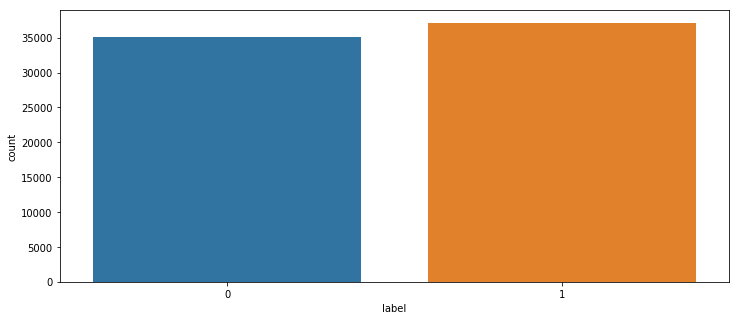

In [6]:
# Show the number/distribution of data
plt.figure(figsize=(12,5))
sns.countplot(x='label', data=messages)

Find out what the 1 stands for and what the 0 stands for. The description of the data on the homepage says: “The data set contains four columns: Serial Number (starting at 0); Title (message heading); Text (message content); and Designation (0 = fake and 1 = real).”

When reading an article, one comes to the conclusion that the labels must be reversed (0 = real and 1 = fake). This is confirmed when reading the publication [WELFake: Word Embedding Over LinguisticFeatures for Fake News Detection](https://www.researchgate.net/publication/350665094_WELFake_Word_Embedding_over_Linguistic_Features_for_Fake_News_Detection). The number of fake news items in this data set is higher than the number of real news items.

Summary: 0 = REAL and 1 = FAKE

In [7]:
# Calculate the percentage of missing data
messages.isna().sum() / (messages.shape[0]) * 100

title    0.773560
text     0.054066
label    0.000000
dtype: float64

In [8]:
# Find all rows with NaN's - save for further action
rows_to_delete = messages[messages.isna().any(axis=1)].index.tolist()
print(len(rows_to_delete))

# Delete the lines with the previously defined NaNs (rows_to_delete)
messages = messages.drop(rows_to_delete)

597


In [9]:
# Check if sucsessful
messages.isna().sum()

title    0
text     0
label    0
dtype: int64

## Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

Duplicate data or deduplication removes redundancy that can lead to biased results.

In [10]:
# How many duplicates are in this dataset?
messages.duplicated().sum()

8416

In [11]:
# Drop the duplicates.
messages.drop_duplicates(inplace=True)

In [12]:
# Check if sucsessful
messages.duplicated().sum()

0

In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63121 entries, 0 to 72132
Data columns (total 3 columns):
title    63121 non-null object
text     63121 non-null object
label    63121 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [14]:
# Calculate the number of fake/real-articles after cleaning
real_cleaned = messages[messages['label']==0].shape[0]
fake_cleaned = messages[messages['label']==1].shape[0]
print('real:', real_cleaned)
print('fake:', fake_cleaned)

real: 34791
fake: 28330


In [15]:
# Calculate the differences before and after cleaning
print('Diff Real:', real - real_cleaned)
print('Diff Fake:', fake - fake_cleaned)

Diff Real: 237
Diff Fake: 8776


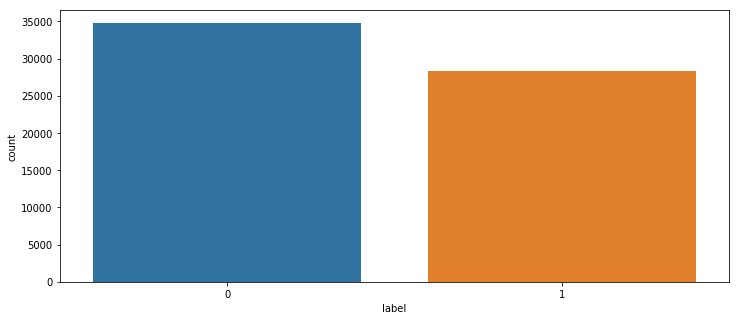

In [16]:
plt.figure(figsize=(12,5))
sns.countplot(x='label', data=messages)

## Feature Engineering

Feature engineering is a crucial step in the machine learning process. It refers to the process of converting raw data into suitable input variables (features) to improve the performance of a model. 

In [17]:
# Function for feature engineering - !!!Attention due to the size of the data set very time-consuming!!!
def count_pos(text):
    
    # Count sentences
    sentence_count = len(nltk.sent_tokenize(text))   
    
    # Count words
    word_count = len(nltk.word_tokenize(text))
    
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    
    # Count verbs
    verb_count = sum(1 for _, pos in tagged if pos.startswith('VB'))
    
    # Count nouns
    noun_count = sum(1 for _, pos in tagged if pos.startswith('NN'))
    
    # Count adjectives
    adjective_count = sum(1 for _, pos in tagged if pos.startswith('JJ'))
    
    # Count selected special characters
    special_characters = r"[#*@!?<>]"
    special_count = len(re.findall(special_characters, text))
    
    return sentence_count, word_count, verb_count, noun_count, adjective_count, special_count

In [15]:
# Adding the engineered feature to the data set
messages[['Count_Sent', 'Count_Word', 'Count_Verb', 'Count_Noun', 'Count_Adj', 'Count_SPEZ']] = messages['text'].apply(lambda x: pd.Series(count_pos(x)))

In [16]:
messages.head()

,title,text,label,Count_Sent,Count_Word,Count_Verb,Count_Noun,Count_Adj,Count_SPEZ
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,47,979,173,243,61,70
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,2,36,8,12,3,0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,48,1514,228,484,96,1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,10,363,53,127,20,0
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,8,280,30,97,18,1


### Graphical representation

Display of the enginered feature to graphically determine whether a distinction seems possible

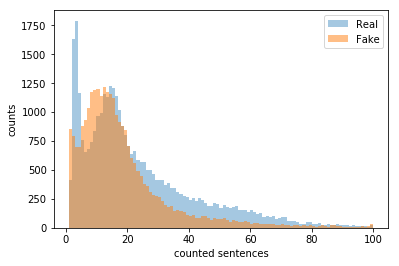

In [19]:
# Representation of the counted sentences
bins = np.linspace(1, 100, 100)
plt.hist(messages[messages['label']== 0]['Count_Sent'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_Sent'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted sentences')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

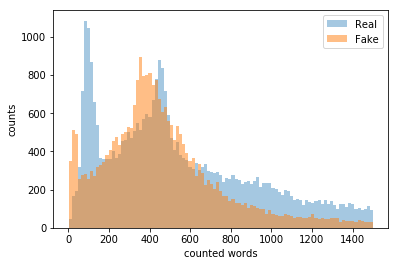

In [20]:
# Representation of the counted words
bins = np.linspace(1, 1500, 100)
plt.hist(messages[messages['label']== 0]['Count_Word'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_Word'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted words')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

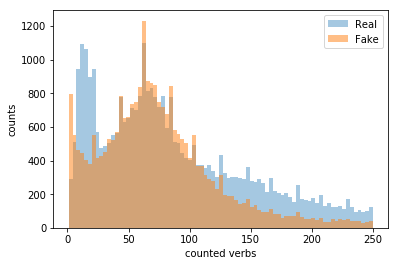

In [21]:
# Representation of the counted verbs
bins = np.linspace(1, 250, 80)
plt.hist(messages[messages['label']== 0]['Count_Verb'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_Verb'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted verbs')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

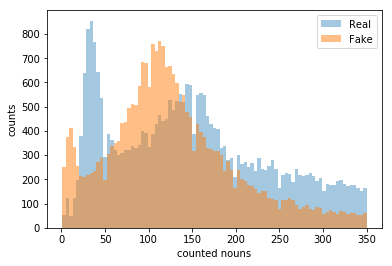

In [22]:
# Representation of the counted nouns
bins = np.linspace(1, 350, 90)
plt.hist(messages[messages['label']== 0]['Count_Noun'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_Noun'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted nouns')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

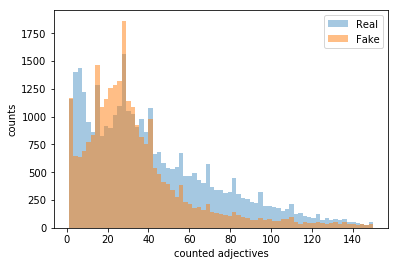

In [23]:
# Representation of the counted adjecives
bins = np.linspace(1, 150, 70)
plt.hist(messages[messages['label']== 0]['Count_Adj'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_Adj'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted adjectives')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

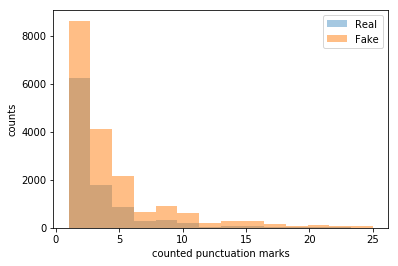

In [24]:
# Representation of the counted punctuation marks
bins = np.linspace(1, 25, 15)
plt.hist(messages[messages['label']== 0]['Count_SPEZ'], bins, alpha=0.4, label="Real")
plt.hist(messages[messages['label']== 1]['Count_SPEZ'], bins, alpha=0.5, label="Fake")
plt.xlabel('counted punctuation marks')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.show()

The distributions show differences between real and fake items. It is therefore perfectly plausible to add these features to the data set.

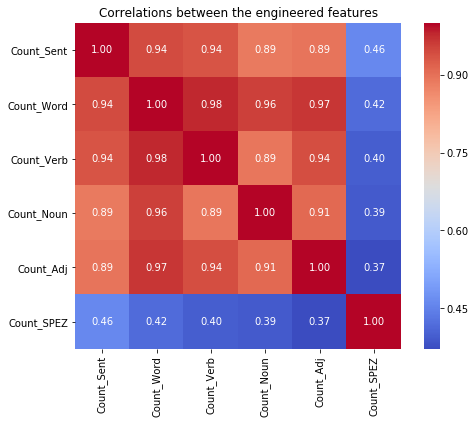

In [25]:
# Calculate Correlationsmatrix
corr = messages[['Count_Sent', 'Count_Word', 'Count_Verb', 'Count_Noun', 'Count_Adj', 'Count_SPEZ']].corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlations between the engineered features')
plt.show()

The parts of speech (verbs, nouns, adjectives) correlate strongly with each other while the punctuation marks do not correlate.

## Save the processed data

Save data after calculation so that you do not have to recalculate the data when the kernel crashes, but can load it from the database.

In [26]:
engine = create_engine('sqlite:///FAKENews.db')
messages.to_sql('tab_FAKENews', engine, index=False, if_exists='replace')

## Load the data

In [27]:
# load data from database
engine = create_engine('sqlite:///FAKENews.db')
messages = pd.read_sql_table('tab_FAKENews', engine)
messages.shape

(63121, 9)

Due to constant crashes of the kernel in the Udacity workspace, I have reduced the data set. However, the ratio between real and fake articles has been maintained.

In [28]:
# Maximum number of rows
max_rows = 2000

# Counting the instances per class in the 'LABEL' column
counts = messages['label'].value_counts()
samples_per_class = {label: min(counts[label], max_rows // len(counts)) for label in counts.index}

# Manual stratified sampling
sampled_dfs = []
for label, num_samples in samples_per_class.items():
    if num_samples > 0:
        sampled_dfs.append(messages[messages['label'] == label].sample(n=num_samples, random_state=42))

# Combining the samples
messages = pd.concat(sampled_dfs).reset_index(drop=True)

# Output of the stratified sample
messages.shape

(2000, 9)

Irrelevant data removes stop words (and other noise) that make the sentence grammatically complete, but do not have semantic significance in news classification operations. Removing stop words and keeping relevant tokens only significantly increases the model performance.


In [29]:
# function for token cleaning
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.lower() not in set(stopwords.words('english')) and len(token)>2]
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    return clean_tokens

In [30]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenize)

# Applying CountVectorizer to the 'TEXT' column
X_count = vectorizer.fit_transform(messages['text'])

# Initializing the TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Applying the TfidfTransformer to the count matrix
X_tfidf = tfidf_transformer.fit_transform(X_count)

# Convert to a DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())

# Scaling the additional features created // Scaling is necessary to be able to compare different algorithms
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(messages[['Count_Sent', 'Count_SPEZ']])

# Converting the scaled features into a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=['Count_Sent', 'Count_SPEZ'])

# Appending the scaled features to the TF-IDF matrix
X_new = pd.concat([tfidf_df, scaled_df], axis=1)

In [31]:
# Define X (Input) and y (Output)
X = X_new
y = messages['label']

print('Shape of X:', X.shape,', Shape of y:', y.shape)

Shape of X: (2000, 44576) , Shape of y: (2000,)


In [32]:
# Split into train and test set; chosen random_state ensures same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Train the models



In [33]:
# Initializing Naive Bayes
nb_model = MultinomialNB()

# train model
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
# Initializing AdaBoostClassifier
adaboost_model = AdaBoostClassifier(random_state=42)

# train model
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)

In [35]:
# Initializing Logistische Regression
log_reg_model = LogisticRegression(random_state=42)

# train model
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
# Initializing SVM
svc_model = SVC(C=3, kernel='linear', probability=True)

# train model
svc_model.fit(X_train, y_train)

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Testing the models
Report the f1 score, precision and recall for each output category of the dataset.

In [37]:
# function to obtain the indices (articles) that were false positives and false negatives
def falsepred(y_pred, y_test):
    # Indizes der falsch positiven und falsch negativen Vorhersagen finden
    false_positives = np.where((y_pred == 1) & (y_test == 0))[0]
    false_negatives = np.where((y_pred == 0) & (y_test == 1))[0]
    
    return false_positives, false_negatives

In [38]:
# Prediction
y_pred_nb = nb_model.predict(X_test)

# classification report on test data
print(classification_report(y_test.values, y_pred_nb))

# Find Article index false positiv / false negativ
false_positives_nb, false_negative_nb = falsepred(y_pred_nb, y_test.values)

             precision    recall  f1-score   support

          0       0.82      0.87      0.85       257
          1       0.85      0.80      0.83       243

avg / total       0.84      0.84      0.84       500



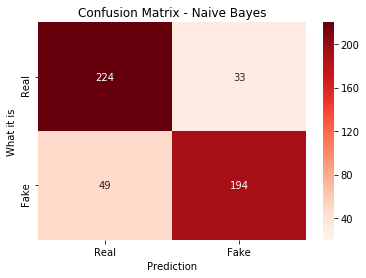

In [39]:
# Visualization of the results
cm_NaiveBayes = confusion_matrix(y_test.values, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_NaiveBayes, vmin=20, vmax=220, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [40]:
# Prediction
y_pred_adaboost = adaboost_model.predict(X_test)

# classification report on test data
print(classification_report(y_test.values, y_pred_adaboost))

# Find Article index false positiv / false negativ
false_positives_ab, false_negative_ab = falsepred(y_pred_adaboost, y_test.values)

             precision    recall  f1-score   support

          0       0.94      0.89      0.92       257
          1       0.89      0.94      0.92       243

avg / total       0.92      0.92      0.92       500



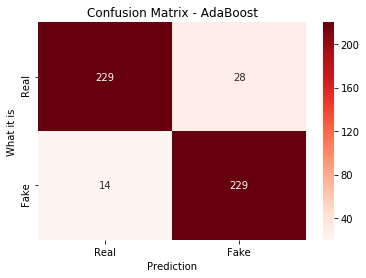

In [41]:
# Visualization of the results
cm_adaboost = confusion_matrix(y_test.values, y_pred_adaboost)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_adaboost, vmin=20, vmax=220, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

In [42]:
# Prediction
y_pred_logreg = log_reg_model.predict(X_test)

# classification report on test data
print(classification_report(y_test.values, y_pred_logreg))

# Find Article index false positiv / false negativ
false_positives_lg, false_negative_lg = falsepred(y_pred_logreg, y_test.values)

             precision    recall  f1-score   support

          0       0.92      0.86      0.89       257
          1       0.86      0.92      0.89       243

avg / total       0.89      0.89      0.89       500



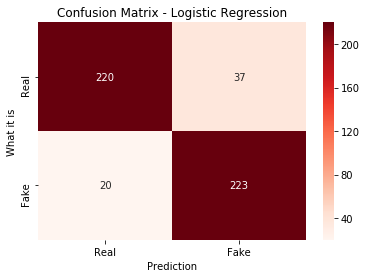

In [43]:
# Visualization of the results
cm_logreg = confusion_matrix(y_test.values, y_pred_logreg)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, vmin=20, vmax=220, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [44]:
# Prediction
y_pred_svc = svc_model.predict(X_test)

# classification report on test data
print(classification_report(y_test.values, y_pred_svc))

# Find Article index false positiv / false negativ
false_positives_sv, false_negative_sv = falsepred(y_pred_svc, y_test.values)

             precision    recall  f1-score   support

          0       0.92      0.86      0.89       257
          1       0.86      0.93      0.89       243

avg / total       0.89      0.89      0.89       500



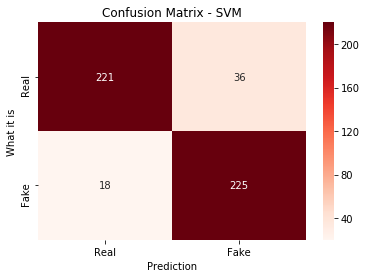

In [45]:
# Visualization of the results
cm_svm = confusion_matrix(y_test.values, y_pred_svc)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, vmin=20, vmax=220, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - SVM')
plt.show()

## Tuning/Optimization of the model

Compare the false negative classified articles of the three best algorithms to determine if voting could help. Is it every time the same article which is classified wrong?

In [50]:
# Combine all lists into a single list
all_indices = set(false_negative_lg.tolist()) | set(false_negative_ab.tolist()) | set(false_negative_sv.tolist())

# Create matrix
matrix = []

for index in all_indices:
    row = [
        1 if index in false_negative_lg.tolist() else 0,
        1 if index in false_negative_ab.tolist() else 0,
        1 if index in false_negative_sv.tolist() else 0
    ]
    matrix.append([index] + row)

# Transform to DataFrame
df_matrix = pd.DataFrame(matrix, columns=['Article', 'LogReg', 'AdaBo', 'SVM'])

# Sort by Index
df_matrix = df_matrix.sort_values(by='Article')

# print Matrix for visuell evaluation
df_matrix

,Article,LogReg,AdaBo,SVM
0,0,1,1,1
2,2,1,0,1
4,5,1,0,0
10,41,1,0,1
13,52,1,0,1
16,55,1,1,1
19,73,1,0,1
22,84,1,0,1
24,94,0,0,1
1,128,1,0,0


It seems that the different algorithms classify the articles differently. Therefore a VotingClassifier may improve accuracy! Let's test it!

In [48]:
# Combine the models in a voting classifier
voting_model = VotingClassifier(estimators=[
    ('ab', adaboost_model),
    ('lg', log_reg_model),
    ('sv', svc_model)], 
    voting='hard',                   
    weights=[1,1,1])  

# Train the combined modell
voting_model.fit(X_train, y_train)

# Prediction
y_pred_VOTE = voting_model.predict(X_test)

# classification report on test data
print(classification_report(y_test.values, y_pred_VOTE))

             precision    recall  f1-score   support

          0       0.93      0.87      0.90       257
          1       0.87      0.93      0.90       243

avg / total       0.90      0.90      0.90       500



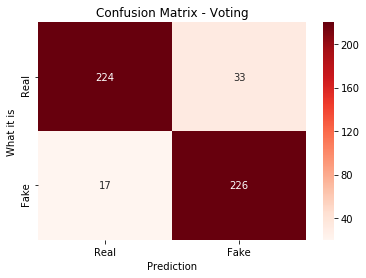

In [49]:
# Visualization of the results
cm_vote = confusion_matrix(y_test.values, y_pred_VOTE)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_vote, vmin=20, vmax=220, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - Voting')
plt.show()

VotingClassifier did not improve the prediction accuracy. The AdaBoostClassifier initially shows the best performance with default values. For further improvement, we are still trying to optimize the model parameters.

In [51]:
# get list of model parameters
adaboost_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [52]:
# set parameters for GridSearch
parameters = {
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [10, 50, 100, 150, 200]
}

cv = GridSearchCV(adaboost_model, param_grid=parameters, verbose=10, cv=2)
cv.fit(X_train, y_train)
print("Best parameters:", cv.best_params_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV]  learning_rate=0.1, n_estimators=10, score=0.8175765645805593, total=   2.3s
[CV] learning_rate=0.1, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=10, score=0.8411214953271028, total=   2.1s
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=50, score=0.9041278295605859, total=   7.7s
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=50, score=0.8878504672897196, total=   7.8s
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.9s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=100, score=0.9121171770972037, total=  16.0s
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.2s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=100, score=0.8918558077436582, total=  15.4s
[CV] learning_rate=0.1, n_estimators=150 .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.9s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=150, score=0.914780292942743, total=  22.5s
[CV] learning_rate=0.1, n_estimators=150 .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=150, score=0.8878504672897196, total=  22.2s
[CV] learning_rate=0.1, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=200, score=0.9161118508655126, total=  30.8s
[CV] learning_rate=0.1, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=200, score=0.8918558077436582, total=  29.6s
[CV] learning_rate=0.5, n_estimators=10 ..............................
[CV]  learning_rate=0.5, n_estimators=10, score=0.8948069241011984, total=   2.3s
[CV] learning_rate=0.5, n_estimators=10 ..............................
[CV]  learning_rate=0.5, n_estimators=10, score=0.8838451268357811, total=   2.3s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=0.9054593874833555, total=   8.2s
[CV] learning_rate=0.5, n_estimators=50 ..............................
[CV]  learning_rate=0.5, n_estimators=50, score=0.8918558077436582, total=   7.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV]  learning_rate=0.5, n_estimators=100, score=0.9094540612516645, total=  14.8s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV]  learning_rate=0.5, n_estimators=100, score=0.9038718291054739, total=  14.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.4min finished


Best parameters: {'learning_rate': 0.5, 'n_estimators': 100}


In [53]:
# Prediction of the optimized model based on the test data
y_pred_cv = cv.predict(X_test)
# classification report on test data
print(classification_report(y_test.values, y_pred_cv))

             precision    recall  f1-score   support

          0       0.95      0.88      0.91       257
          1       0.88      0.95      0.91       243

avg / total       0.91      0.91      0.91       500



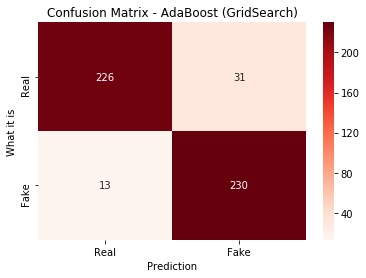

In [54]:
# Visualization of the results
cm = confusion_matrix(y_test.values, y_pred_cv)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('What it is')
plt.xlabel('Prediction')
plt.title('Confusion Matrix - AdaBoost (GridSearch)')
plt.show()

## Feature Importance

Has feature engineering helped - are these features significant for the model?

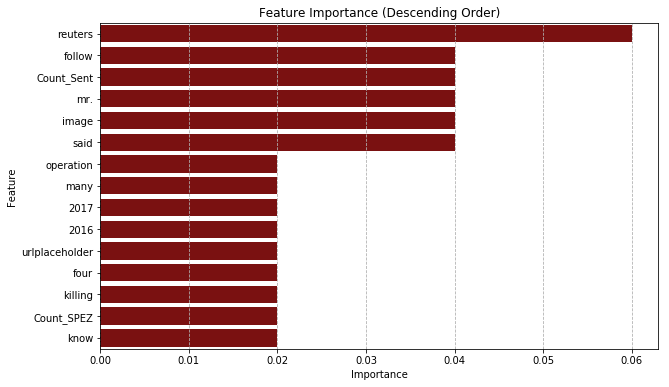

In [58]:
# Feature Importance
importances = adaboost_model.feature_importances_
feature_names = X_new.columns.tolist()

# Convert to DataFrame and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the first 15 features
top_n = 15
top_importance_df = importance_df.head(top_n)

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_importance_df, color='darkred')
plt.xlabel('Importance')
plt.title('Feature Importance (Descending Order)')
plt.grid(axis='x', linestyle='--')
plt.show()

Yes, two of the additional features created are included in the top 15 features. 

## Show result

In [61]:
# Choose three articels (random) make a prediction and check for correctness
for i in range(3):
    id = np.random.choice(range(len(messages)))

    print('\033[1m'+messages['title'][id]+'\n')
    print('\033[0m'+messages['text'][id])

    pred = adaboost_model.predict(X.loc[[id]])
    result_pred = 'Fake' if pred == 1 else 'Real'

    label = messages['label'][id]
    result_label = 'Fake' if pred == 1 else 'Real'  
          
    print('\n')
    print('Prediction: {}'.format(result_pred))
    print('What it is: {}'.format(result_label))
    print('============================================================================================================================\n')

U.S. senators seek answers on U.S. presence in Niger after ambush

WASHINGTON (Reuters) - U.S. senators said on Sunday the White House has not been forthcoming with details about the military s presence in Niger after the deaths of four soldiers there earlier this month and they want more answers on U.S. operations in the west African country. Republican Senator Lindsey Graham and Democratic Senate leader Chuck Schumer said in separate interviews that they support Republican Senator John McCain s effort to get answers from the Pentagon on the ambush and more broadly on the U.S. fight against ISIS in Niger. Graham and Schumer said they had been unaware of the large U.S. presence in the country and said Congress needs more information on what could become a long and open-ended involvement.  I didn t know there was 1,000 troops in Niger,  Graham said on NBC s Meet the Press.  This is an endless war without boundaries and no limitation on time and geography,  he added.  You ve got to tell 